In [2]:
params_dict = {
    "Cora_gnn": {
        "tSNE": {"metric": "cosine", "n_iter": 2000, "perplexity": 30, "learning_rate": 100},
        "UMAP": {"metric": "cosine", "min_dist": 0.1, "n_neighbors": 20},
        "TRIMAP": {"metric": "cosine", "n_inliers": 30, "n_iters": 400, "n_outliers": 4, "n_random": 3}
    },
    "Cora_original": {
        "tSNE": {"metric": "cosine", "n_iter": 2000, "perplexity": 50, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.1, "n_neighbors": 20},
        "TRIMAP": {"metric": "manhattan", "n_inliers": 12, "n_iters": 2000, "n_outliers": 2, "n_random": 1}
    },
    "Amazon_gnn": {
        "tSNE": {"metric": "cosine", "n_iter": 2000, "perplexity": 50, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.25, "n_neighbors": 30},
        "TRIMAP": {"metric": "manhattan", "n_inliers": 30, "n_iters": 2000, "n_outliers": 12, "n_random": 1}
    },
    "Amazon_original": {
        "tSNE": {"metric": "cosine", "n_iter": 2000, "perplexity": 50, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.25, "n_neighbors": 30},
        "TRIMAP": {"metric": "manhattan", "n_inliers": 6, "n_iters": 1000, "n_outliers": 2, "n_random": 1}
    },
    "Coauthor_gnn": {
        "tSNE": {"metric": "cosine", "n_iter": 1000, "perplexity": 100, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.1, "n_neighbors": 20},
        "TRIMAP": {"metric": "cosine", "n_inliers": 30, "n_iters": 1000, "n_outliers": 8, "n_random": 1}
    },
    "Coauthor_original": {
        "tSNE": {"metric": "cosine", "n_iter": 1000, "perplexity": 100, "learning_rate": 500},
        "UMAP": {"metric": "cosine", "min_dist": 0.1, "n_neighbors": 20},
        "TRIMAP": {"metric": "cosine", "n_inliers": 16, "n_iters": 1000, "n_outliers": 2, "n_random": 6}
    },
}

Training GNN...
GNN Training Time: 2.70 seconds
RAM Memory usage: Current=0.11MB, Peak=0.13MB
GPU Memory usage: 17.31MB
Saving tSNE results...
Calculating d_hd
Cora_original TSNE
t-SNE (Cora_original) Time: 41.82 seconds
t-SNE (Cora_original) RAM Memory usage: Current=0.16MB, Peak=90.37MB
t-SNE (Cora_original) GPU Memory usage: 0.00MB
Saving UMAP results...
Calculating d_hd
Cora_original UMAP
UMAP (Cora_original) Time: 58.62 seconds
UMAP (Cora_original) RAM Memory usage: Current=14.15MB, Peak=127.94MB
UMAP (Cora_original) GPU Memory usage: 0.00MB
Saving TRIMAP results...
Calculating d_hd
Cora_original TRIMAP
TRIMAP (Cora_original) Time: 15.08 seconds
TRIMAP (Cora_original) RAM Memory usage: Current=2.07MB, Peak=32.44MB
TRIMAP (Cora_original) GPU Memory usage: 0.00MB
Saving tSNE results...
Calculating d_hd
Cora_gnn TSNE
t-SNE (Cora_gnn) Time: 41.56 seconds
t-SNE (Cora_gnn) RAM Memory usage: Current=0.04MB, Peak=87.83MB
t-SNE (Cora_gnn) GPU Memory usage: 0.00MB
Saving UMAP results...
Cal

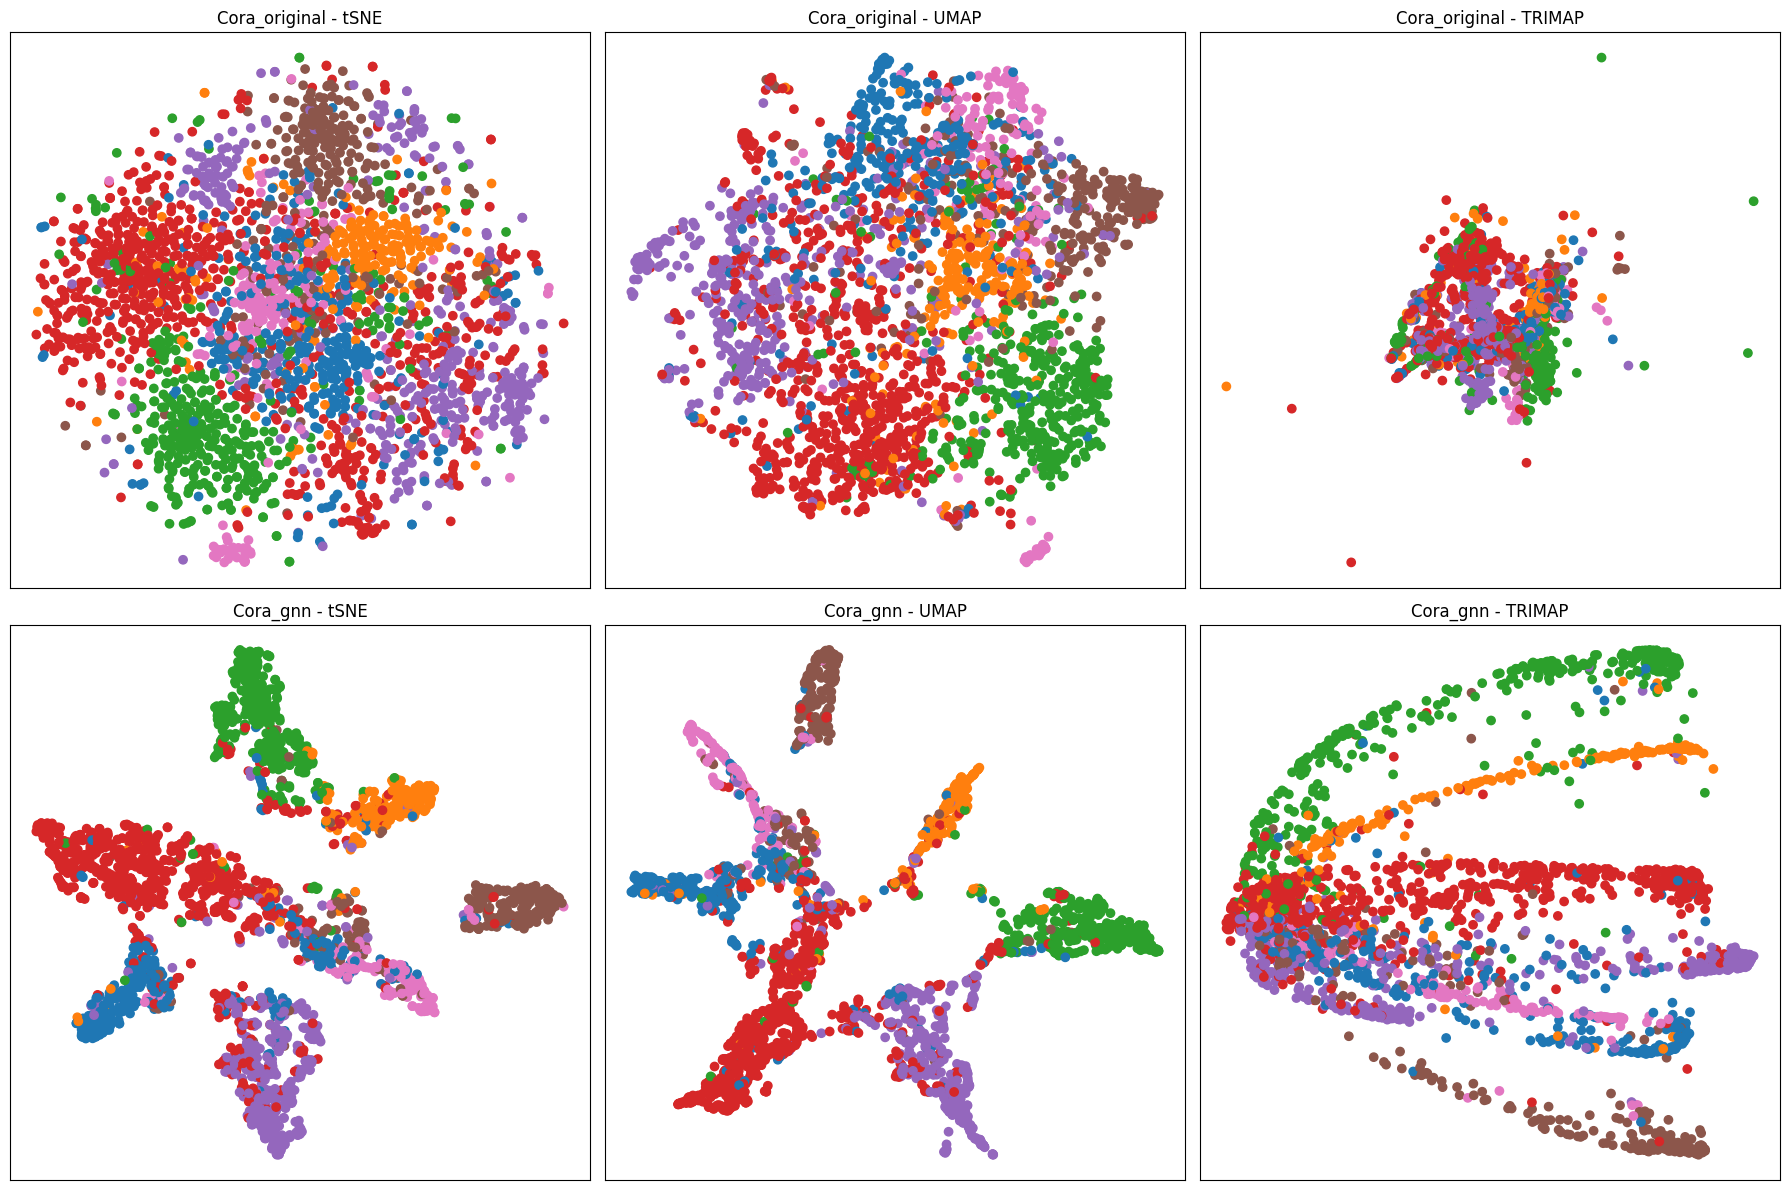

Finished.


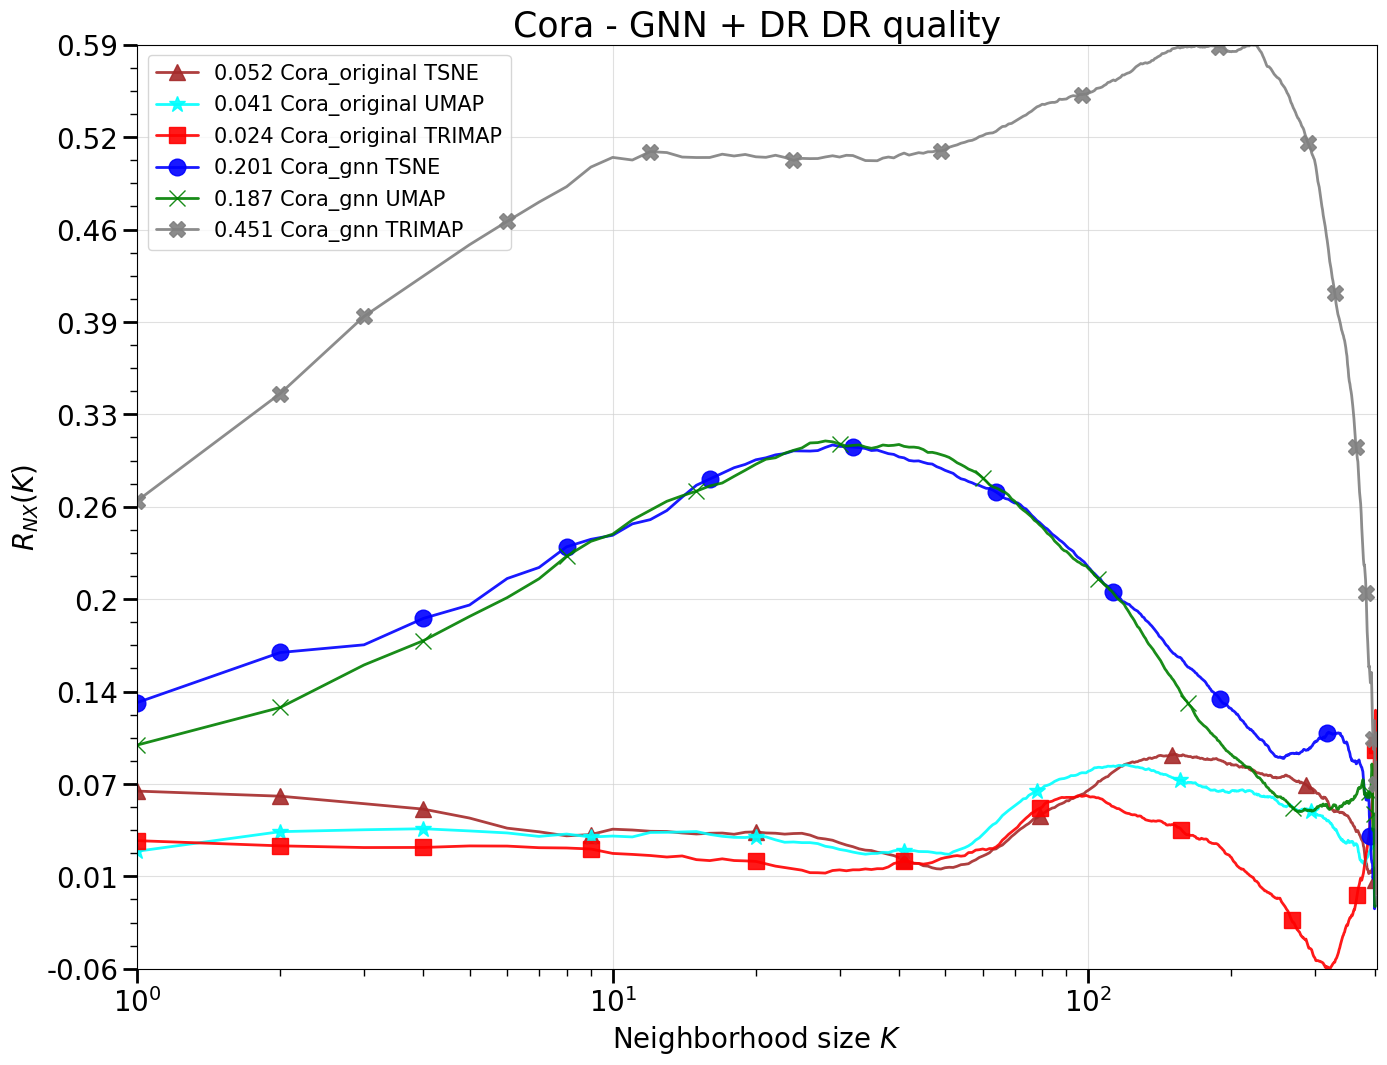

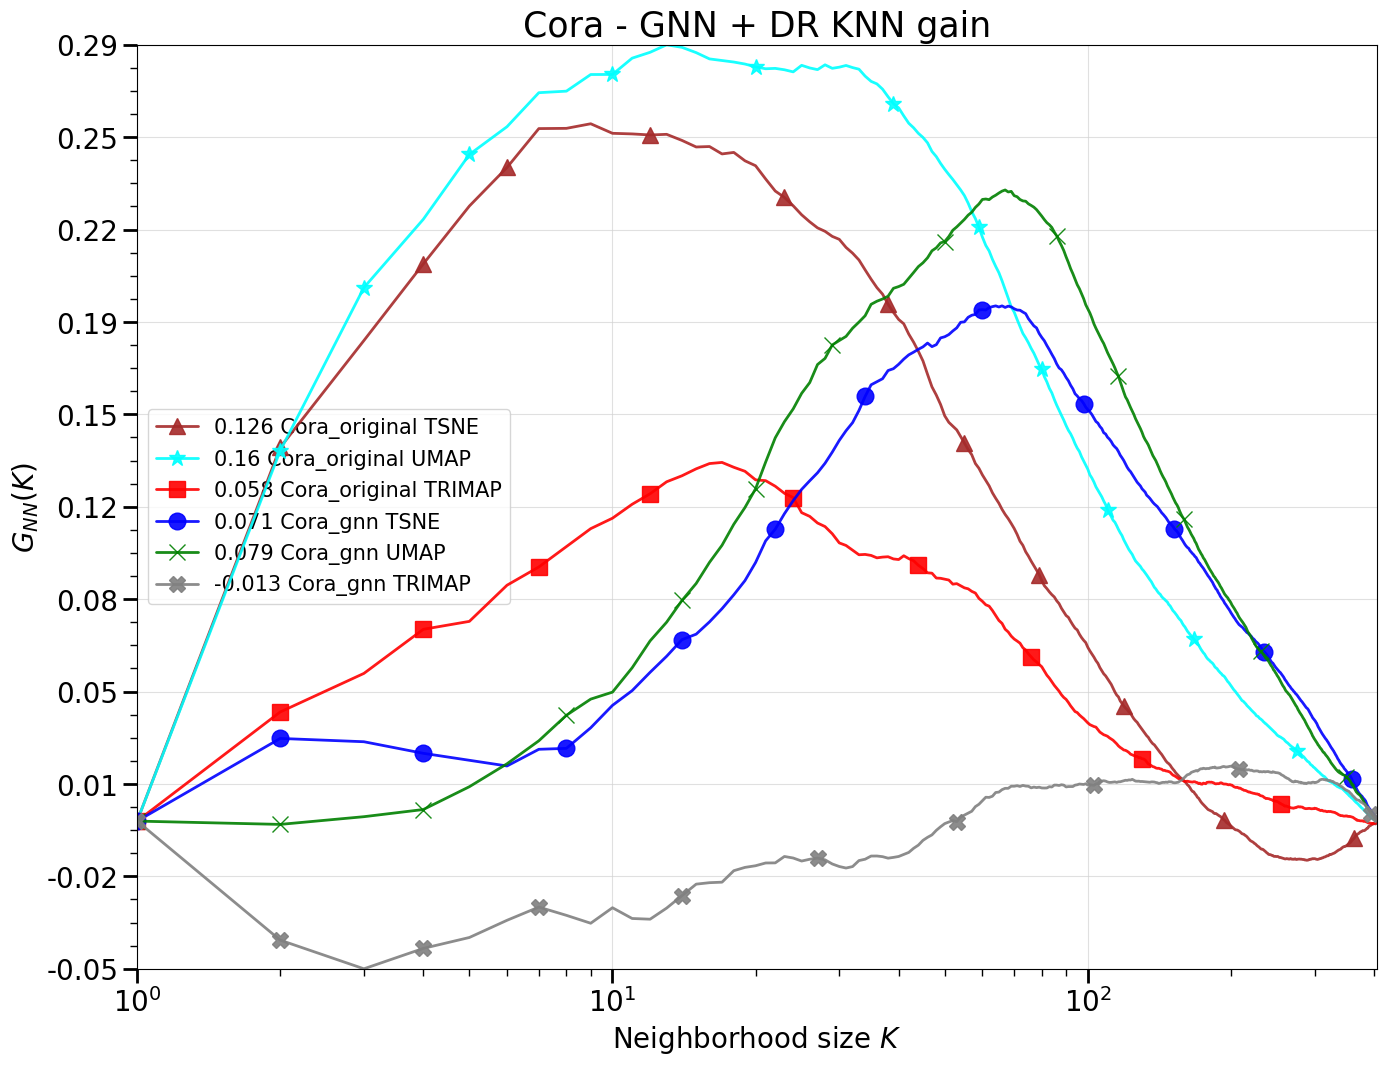

In [2]:
import time
import numpy as np
import torch
from sklearn.manifold import TSNE
import umap
import trimap
import tracemalloc
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv, GAE
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)

# Sample data for illustration, replace these with actual data loading and processing
def load_data():
    dataset = Planetoid(root='.', name='Cora', transform=None)
    data = dataset[0]
    return data.x.numpy(), data.y.numpy()

def load_gnn_output():
    dataset = Planetoid(root='.', name='Cora', transform=None)
    data = dataset[0].to(device)
    
    model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training the GAE model to encode node features into 2D
    print("Training GNN...")
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    train_loop(200, model, optimizer, data)
    
    end_time = time.time()
    end_gpu_memory = get_gpu_memory()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"GNN Training Time: {end_time - start_time:.2f} seconds")
    print(f"RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    # Extract features with the trained GNN
    model.eval()
    with torch.no_grad():
        gnn_output = model(data)
    
    # Move the features to CPU
    gnn_output = gnn_output.cpu().numpy()
    
    return gnn_output, data.y.cpu().numpy()



# Load datasets
cora_data, cora_labels = load_data()
gnn_output, gnn_labels = load_gnn_output()


# Initialize subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

local_metrics = LocalMetric()

# Function to apply dimensionality reduction and plot
def apply_dr_and_plot(dataset_name, data, labels, row):    
    # tSNE
    tsne_params = params_dict[f"{dataset_name}"]["tSNE"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    tsne = TSNE(metric=tsne_params["metric"], n_iter=tsne_params["n_iter"], perplexity=tsne_params["perplexity"], learning_rate=tsne_params["learning_rate"])
    tsne_results = tsne.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving tSNE results...")
    algorithm_name = "TSNE"
    df = pd.DataFrame(tsne_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = labels
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=tsne_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"t-SNE ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"t-SNE ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"t-SNE ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 0], tsne_results, labels, f"{dataset_name} - tSNE")

    # UMAP
    umap_params = params_dict[f"{dataset_name}"]["UMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    umap_model = umap.UMAP(metric=umap_params["metric"], min_dist=umap_params["min_dist"], n_neighbors=umap_params["n_neighbors"])
    umap_results = umap_model.fit_transform(data)
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving UMAP results...")
    algorithm_name = "UMAP"
    df = pd.DataFrame(umap_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = labels
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=umap_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"UMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"UMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"UMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 1], umap_results, labels, f"{dataset_name} - UMAP")

    # TRIMAP
    trimap_params = params_dict[f"{dataset_name}"]["TRIMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    trimap_model = trimap.TRIMAP(distance=trimap_params["metric"], n_inliers=trimap_params["n_inliers"], n_iters=trimap_params["n_iters"], n_outliers=trimap_params["n_outliers"], n_random=trimap_params["n_random"])
    trimap_results = trimap_model.fit_transform(data)
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving TRIMAP results...")
    algorithm_name = "TRIMAP"
    df = pd.DataFrame(trimap_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = labels
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=trimap_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"TRIMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"TRIMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"TRIMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 2], trimap_results, labels, f"{dataset_name} - TRIMAP")

# Process Cora_original
apply_dr_and_plot("Cora_original", cora_data, cora_labels, 0)

# Process Cora_gnn
apply_dr_and_plot("Cora_gnn", gnn_output, gnn_labels, 1)

# Adjust layout
plt.tight_layout()
plt.show()

local_metrics.visualize(f"Cora - GNN + DR")

Training GNN...
GNN Training Time: 15.02 seconds
RAM Memory usage: Current=0.11MB, Peak=0.13MB
GPU Memory usage: 16.83MB
Saving tSNE results...
Calculating d_hd
Amazon_original TSNE
t-SNE (Amazon_original) Time: 309.41 seconds
t-SNE (Amazon_original) RAM Memory usage: Current=0.25MB, Peak=1558.72MB
t-SNE (Amazon_original) GPU Memory usage: 0.00MB
Saving UMAP results...
Calculating d_hd
Amazon_original UMAP
UMAP (Amazon_original) Time: 116.62 seconds
UMAP (Amazon_original) RAM Memory usage: Current=140.15MB, Peak=378.22MB
UMAP (Amazon_original) GPU Memory usage: 0.00MB
Saving TRIMAP results...
Calculating d_hd
Amazon_original TRIMAP
TRIMAP (Amazon_original) Time: 30.63 seconds
TRIMAP (Amazon_original) RAM Memory usage: Current=3.85MB, Peak=91.87MB
TRIMAP (Amazon_original) GPU Memory usage: 0.00MB
Saving tSNE results...
Calculating d_hd
Amazon_gnn TSNE
t-SNE (Amazon_gnn) Time: 253.09 seconds
t-SNE (Amazon_gnn) RAM Memory usage: Current=0.12MB, Peak=1558.66MB
t-SNE (Amazon_gnn) GPU Memory

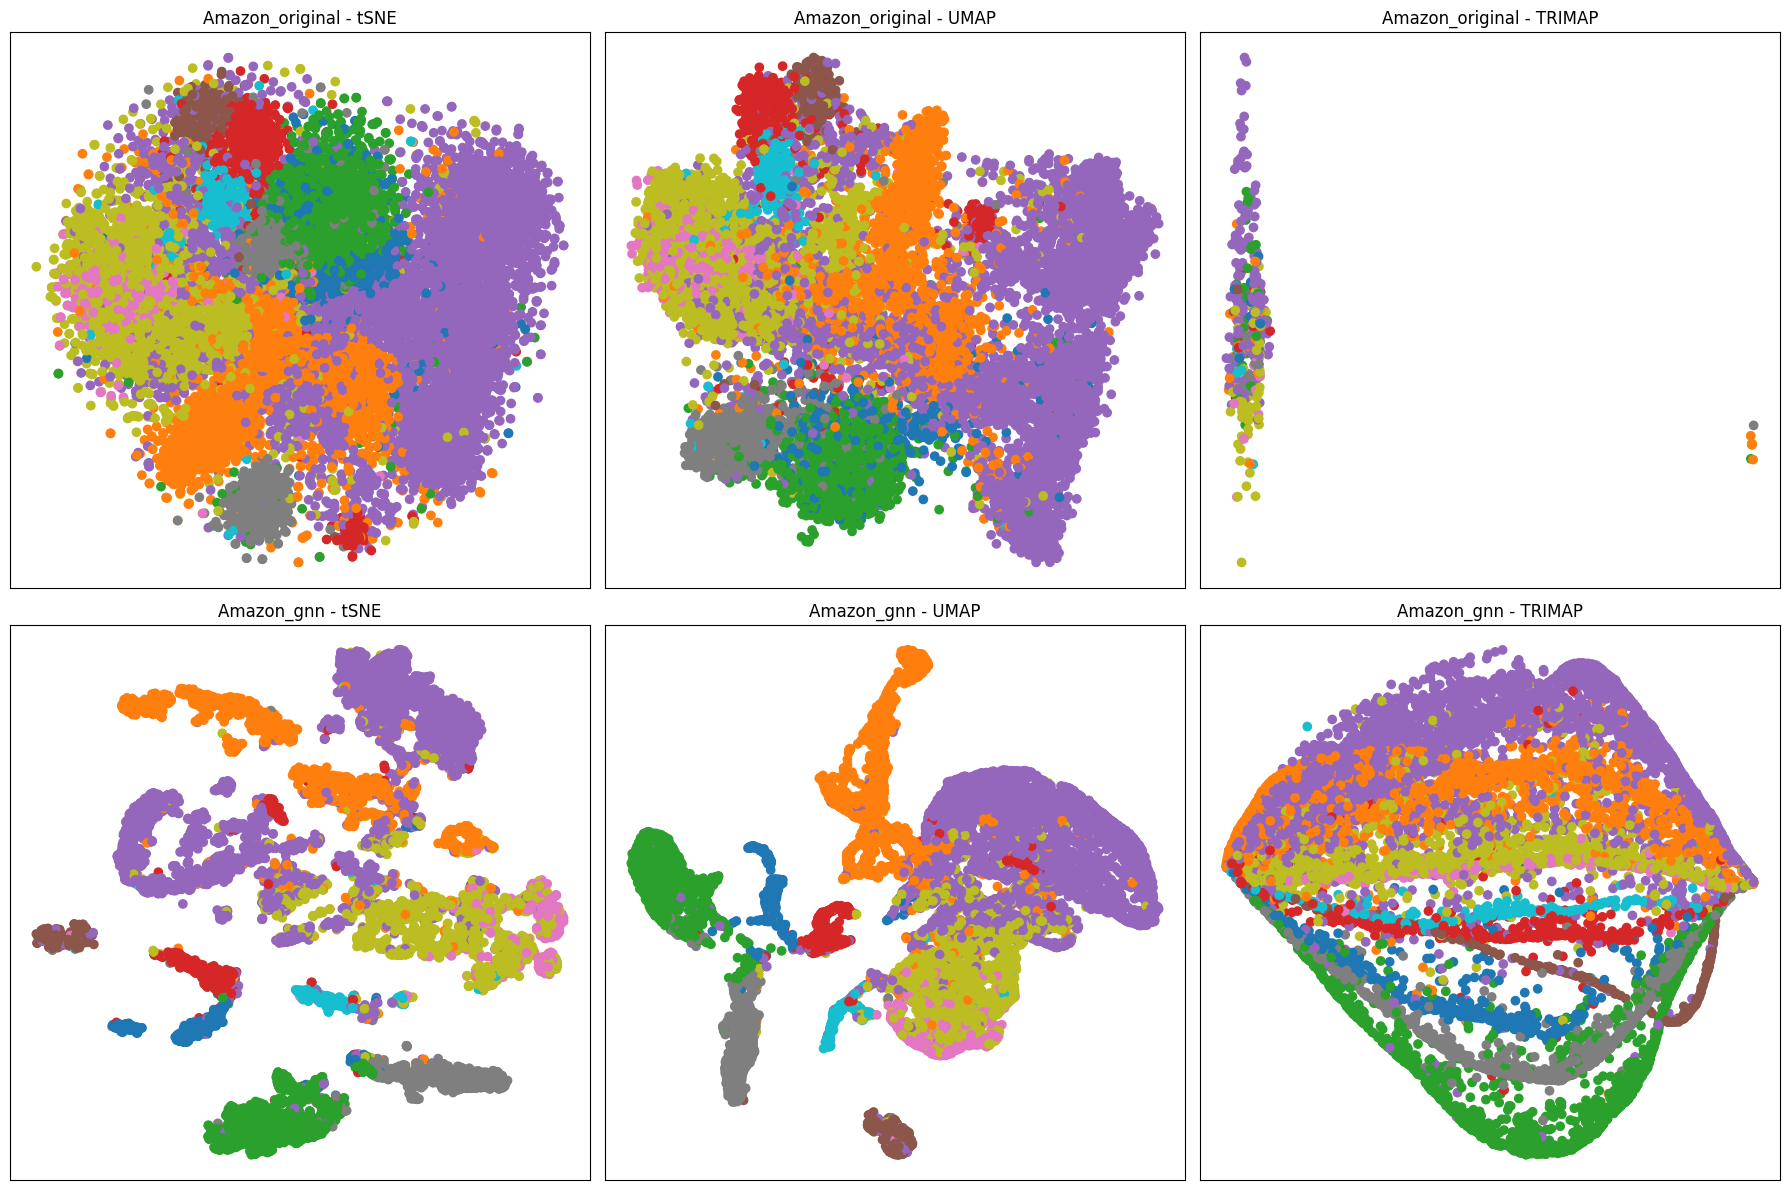

Finished.


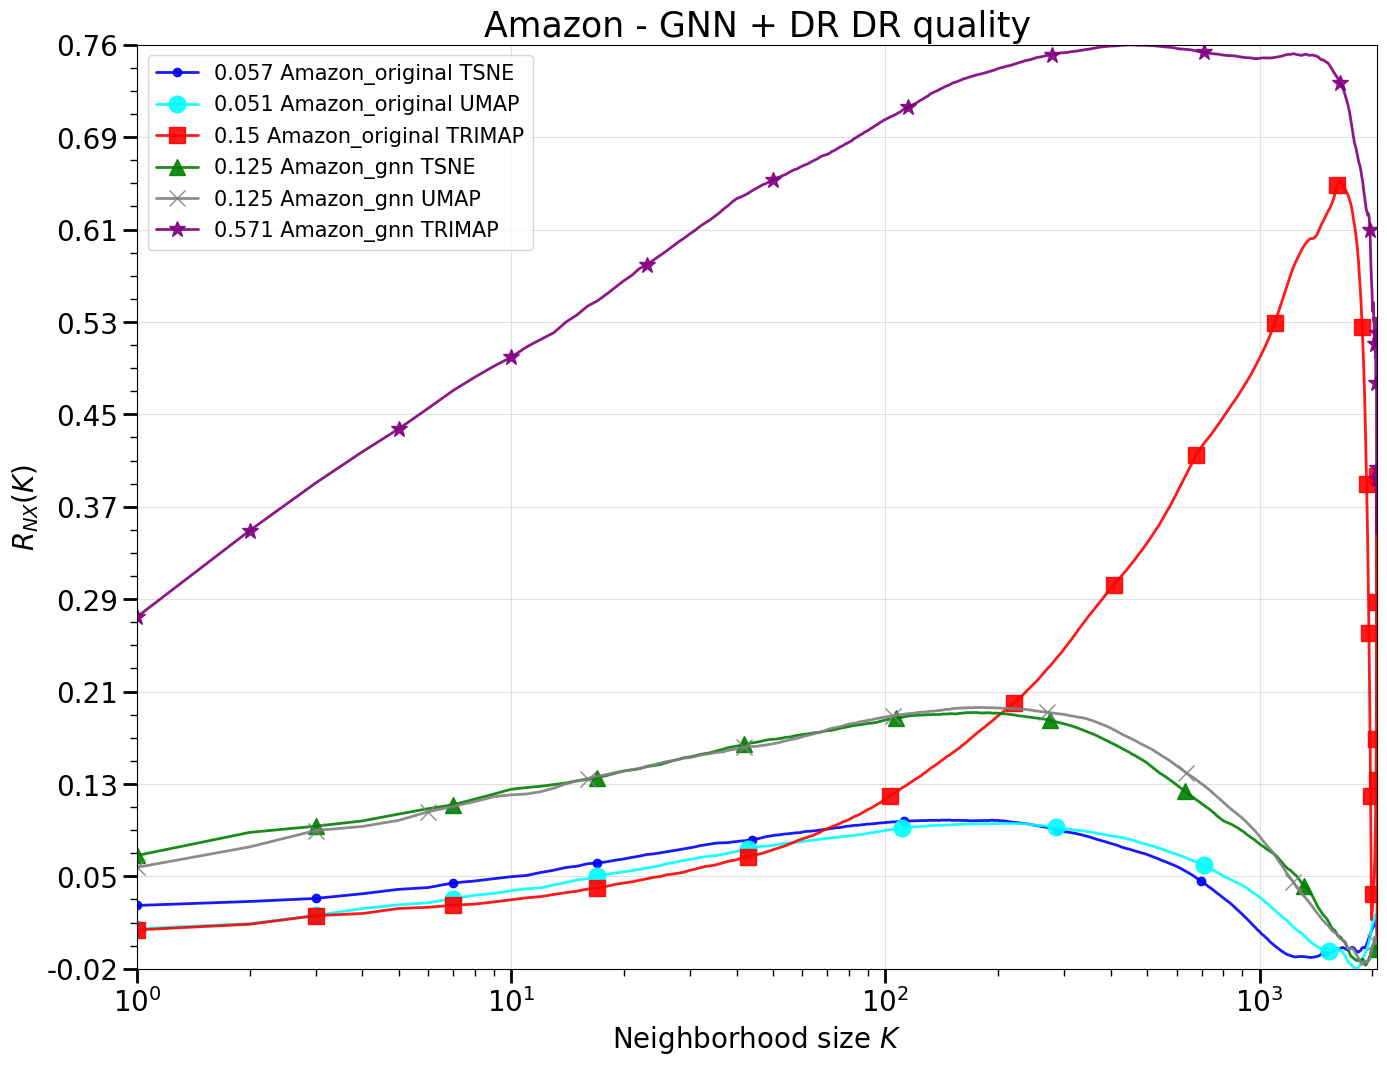

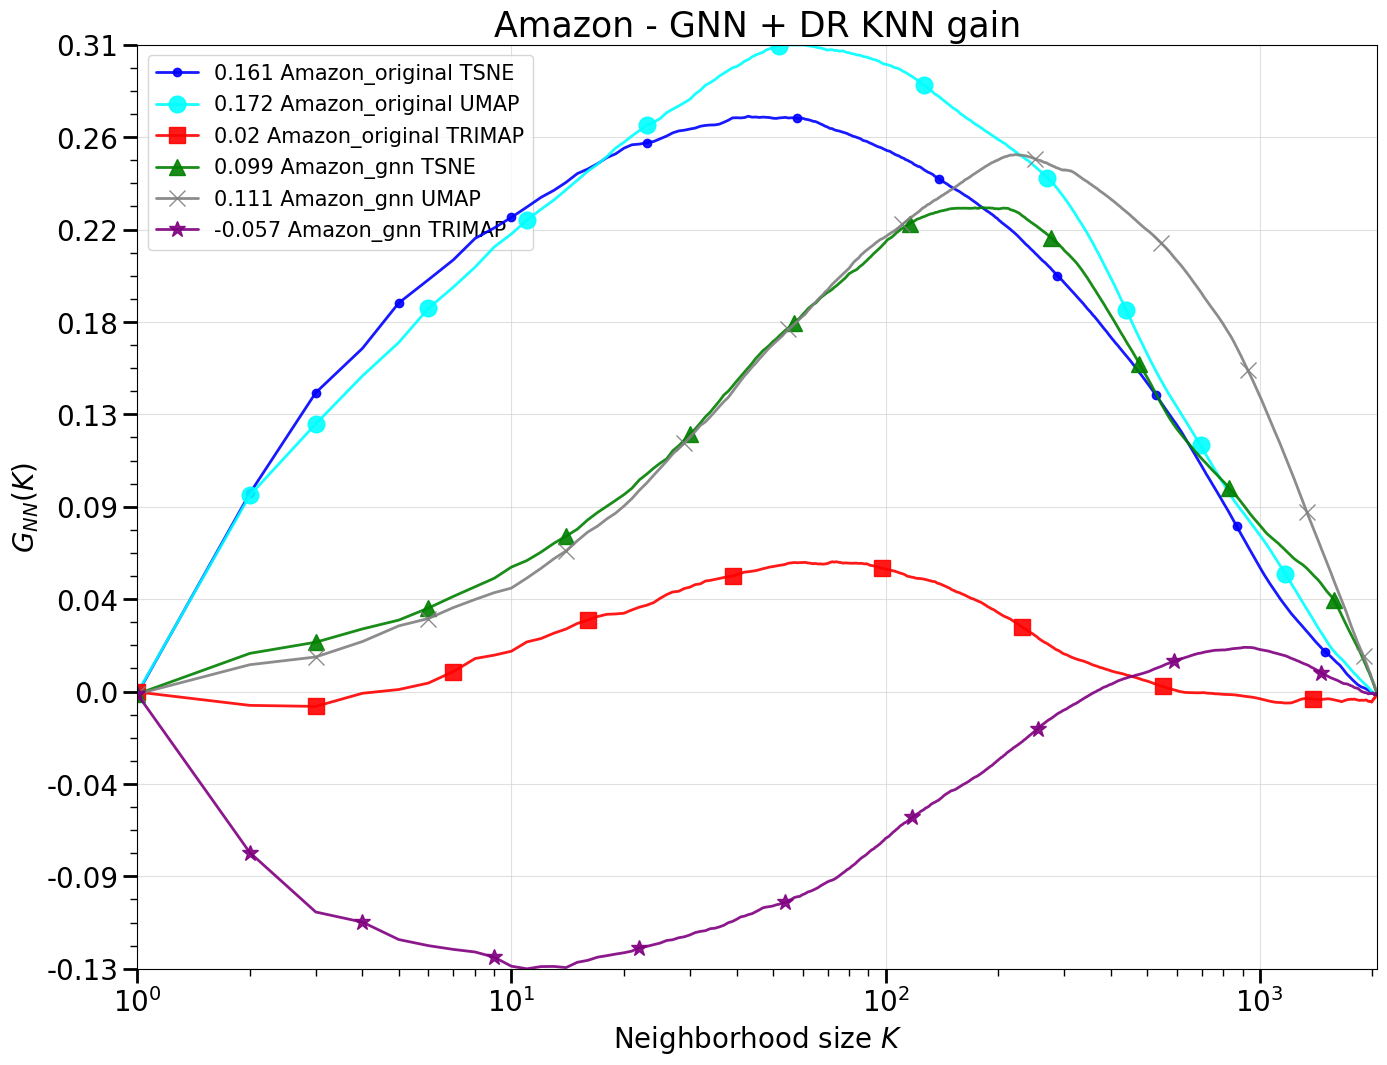

In [3]:
import time
import numpy as np
import torch
from sklearn.manifold import TSNE
import umap
import trimap
import tracemalloc
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
from torch_geometric.datasets import Amazon
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv, GAE
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)

# Sample data for illustration, replace these with actual data loading and processing
def load_data():
    dataset = Amazon(root='.', name='Computers', transform=None)
    data = dataset[0]
    return data.x.numpy(), data.y.numpy()

def load_gnn_output():
    dataset = Amazon(root='.', name='Computers', transform=None)
    data = dataset[0].to(device)

    generate_train_test(data)
    
    model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training the GAE model to encode node features into 2D
    print("Training GNN...")
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    train_loop(200, model, optimizer, data)
    
    end_time = time.time()
    end_gpu_memory = get_gpu_memory()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"GNN Training Time: {end_time - start_time:.2f} seconds")
    print(f"RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    # Extract features with the trained GNN
    model.eval()
    with torch.no_grad():
        gnn_output = model(data)
    
    # Move the features to CPU
    gnn_output = gnn_output.cpu().numpy()
    
    return gnn_output, data.y.cpu().numpy()



# Load datasets
cora_data, cora_labels = load_data()
gnn_output, gnn_labels = load_gnn_output()


# Initialize subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

local_metrics = LocalMetric()

# Function to apply dimensionality reduction and plot
def apply_dr_and_plot(dataset_name, data, labels, row):

   
    # tSNE
    tsne_params = params_dict[f"{dataset_name}"]["tSNE"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    tsne = TSNE(metric=tsne_params["metric"], n_iter=tsne_params["n_iter"], perplexity=tsne_params["perplexity"], learning_rate=tsne_params["learning_rate"])
    tsne_results = tsne.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving tSNE results...")
    algorithm_name = "TSNE"
    df = pd.DataFrame(tsne_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = labels
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=tsne_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"t-SNE ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"t-SNE ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"t-SNE ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 0], tsne_results, labels, f"{dataset_name} - tSNE")

    # UMAP
    umap_params = params_dict[f"{dataset_name}"]["UMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    umap_model = umap.UMAP(metric=umap_params["metric"], min_dist=umap_params["min_dist"], n_neighbors=umap_params["n_neighbors"])
    umap_results = umap_model.fit_transform(data)
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving UMAP results...")
    algorithm_name = "UMAP"
    df = pd.DataFrame(umap_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = labels
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=umap_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"UMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"UMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"UMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 1], umap_results, labels, f"{dataset_name} - UMAP")

    # TRIMAP
    trimap_params = params_dict[f"{dataset_name}"]["TRIMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    trimap_model = trimap.TRIMAP(distance=trimap_params["metric"], n_inliers=trimap_params["n_inliers"], n_iters=trimap_params["n_iters"], n_outliers=trimap_params["n_outliers"], n_random=trimap_params["n_random"])
    trimap_results = trimap_model.fit_transform(data)
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving TRIMAP results...")
    algorithm_name = "TRIMAP"
    df = pd.DataFrame(trimap_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = labels
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=trimap_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"TRIMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"TRIMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"TRIMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 2], trimap_results, labels, f"{dataset_name} - TRIMAP")

# Process Cora_original
apply_dr_and_plot("Amazon_original", cora_data, cora_labels, 0)

# Process Cora_gnn
apply_dr_and_plot("Amazon_gnn", gnn_output, gnn_labels, 1)

# Adjust layout
plt.tight_layout()
plt.show()

local_metrics.visualize(f"Amazon - GNN + DR")

In [ ]:
import time
import numpy as np
import torch
from sklearn.manifold import TSNE
import umap
import trimap
import tracemalloc
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
from torch_geometric.datasets import Coauthor
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv, GAE
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)

# Sample data for illustration, replace these with actual data loading and processing
def load_data():
    dataset = Coauthor(root='.', name='Physics', transform=None)
    data = dataset[0]
    return data.x.numpy(), data.y.numpy()

def load_gnn_output():
    dataset = Coauthor(root='.', name='Physics', transform=None)
    data = dataset[0].to(device)
    
    model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training the GAE model to encode node features into 2D
    print("Training GNN...")
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()

    train_loop(200, model, optimizer, data)
    
    end_time = time.time()
    end_gpu_memory = get_gpu_memory()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"GNN Training Time: {end_time - start_time:.2f} seconds")
    print(f"RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")

    # Extract features with the trained GNN
    model.eval()
    with torch.no_grad():
        gnn_output = model(data)
    
    # Move the features to CPU
    gnn_output = gnn_output.cpu().numpy()
    
    return gnn_output, data.y.cpu().numpy()



# Load datasets
cora_data, cora_labels = load_data()
gnn_output, gnn_labels = load_gnn_output()


# Initialize subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

local_metrics = LocalMetric()

# Function to apply dimensionality reduction and plot
def apply_dr_and_plot(dataset_name, data, labels, row):
    
    # tSNE
    tsne_params = params_dict[f"{dataset_name}"]["tSNE"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    tsne = TSNE(metric=tsne_params["metric"], n_iter=tsne_params["n_iter"], perplexity=tsne_params["perplexity"], learning_rate=tsne_params["learning_rate"])
    tsne_results = tsne.fit_transform(data)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving tSNE results...")
    algorithm_name = "TSNE"
    df = pd.DataFrame(tsne_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = y
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=tsne_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"t-SNE ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"t-SNE ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"t-SNE ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 0], tsne_results, labels, f"{dataset_name} - tSNE")

    # UMAP
    umap_params = params_dict[f"{dataset_name}"]["UMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    umap_model = umap.UMAP(metric=umap_params["metric"], min_dist=umap_params["min_dist"], n_neighbors=umap_params["n_neighbors"])
    umap_results = umap_model.fit_transform(data)
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving UMAP results...")
    algorithm_name = "UMAP"
    df = pd.DataFrame(umap_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = y
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=umap_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"UMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"UMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"UMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 1], umap_results, labels, f"{dataset_name} - UMAP")

    # TRIMAP
    trimap_params = params_dict[f"{dataset_name}"]["TRIMAP"]
    tracemalloc.start()
    start_time = time.time()
    start_gpu_memory = get_gpu_memory()
    
    trimap_model = trimap.TRIMAP(distance=trimap_params["metric"], n_inliers=trimap_params["n_inliers"], n_iters=trimap_params["n_iters"], n_outliers=trimap_params["n_outliers"], n_random=trimap_params["n_random"])
    trimap_results = trimap_model.fit_transform(data)
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_gpu_memory = get_gpu_memory()
    end_time = time.time()

    print("Saving TRIMAP results...")
    algorithm_name = "TRIMAP"
    df = pd.DataFrame(trimap_results, columns=[f'{algorithm_name}1', f'{algorithm_name}2'])
    df['label'] = y
    df.to_csv(f'{dataset_name}_{algorithm_name}_best_params.csv', index=False)

    local_metrics.calculate_knn_gain_and_dr_quality(
        X_lds=trimap_results,
        X_hds=data,
        labels=labels,
        method_name="{} {}".format(dataset_name, algorithm_name),
    )
    
    print(f"TRIMAP ({dataset_name}) Time: {end_time - start_time:.2f} seconds")
    print(f"TRIMAP ({dataset_name}) RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"TRIMAP ({dataset_name}) GPU Memory usage: {end_gpu_memory - start_gpu_memory:.2f}MB")
    
    plot_no_show(axs[row, 2], trimap_results, labels, f"{dataset_name} - TRIMAP")

# Process Cora_original
apply_dr_and_plot("Coauthor_original", cora_data, cora_labels, 0)

# Process Cora_gnn
apply_dr_and_plot("Coauthor_gnn", gnn_output, gnn_labels, 1)

# Adjust layout
plt.tight_layout()
plt.show()

local_metrics.visualize(f"Coauthor - GNN + DR")